# <font color='GREY'> Sistema de Classificação de Risco para Concessão de Empréstimo </font>  




![alt text](https://blog.megaconsultas.com.br/wp-content/uploads/2019/06/Recuperar-o-Score-de-Cr%C3%A9dito.gif)


# <font color='Black'> **Problema de negócio** </font>

Nesse caso prático, nós precisamos construir um Sistema de classificação de Risco do cliente para aprovação de empréstimos.


![alt text](https://www.goias.gov.br/images/uploads/2017/04/Risco-de-Cr%C3%A9dito-finan%C3%A7as-contas.png)

##### **Fonte dos Dados**

Usaremos a base de dados "**risco.csv**" originada por meio dos dados da **UCI Machine Learning**.

A base de dados pode ser encontrada no link abaixo.

**Link**:

https://archive.ics.uci.edu/ml/index.php

###### **Informações dos dados**

* **id_cliente**  : Número de identificação única do cliente
* **inad**        : Índice de inadimplência do cliente
* **Saldo_contas**: Índice referente aos saldos das contas corrente, poupança e aplicações do cliente
* **Class_Renda** : Índice referente à classificação do cliente de acordo com sua renda.
* **Anotações**   : Índice referente às anotações externas à empresa, tais como anotações SERASA / SPC / BACEN 
* **Risco**       : Risco do Cliente atribuído dadas as variáveis de análise do cliente

# 0.0. IMPORTS 

In [10]:
# Importando Bibliotecas 
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns
from sklearn.svm             import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.preprocessing   import RobustScaler
from sklearn                 import metrics
from IPython.display         import Image
import pylab
%matplotlib inline


## 0.1. Help Funcions 

## 0.2. Loading Data

In [9]:
# Se conectando com os dados - Nesse caso, a Fonte de Dados é um Arquivo
data_raw = pd.read_csv( 'risco.csv' )

# 1.0. DESCRIBE DATA

In [11]:
df1 = data_raw.copy()

## 1.1. Data Dimension

In [21]:
#verificando o shape dos dados
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print('Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 150
Number of Columns: 6


## 1.2. Data Type

In [20]:
#verificando o tipo dos dados
df1.dtypes

id_cliente           int64
anot_cadastrais    float64
indice_inad        float64
class_renda        float64
saldo_contas       float64
Risco               object
dtype: object

## 1.3. Check NA

In [23]:
df1.isna().sum()

id_cliente         0
anot_cadastrais    0
indice_inad        0
class_renda        0
saldo_contas       0
Risco              0
dtype: int64

## 1.4. Describe Statics

In [26]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

### 1.4.1. Numeric Attributes

In [28]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id_cliente,0.0,149.0,149.0,74.500000,74.50,43.300308,0.000000,-1.200000
1,anot_cadastrais,4.3,7.9,3.6,5.843333,5.80,0.825301,0.314911,-0.552064
2,indice_inad,2.0,4.4,2.4,3.054000,3.00,0.432147,0.334053,0.290781
3,class_renda,1.0,6.9,5.9,3.758667,4.35,1.758529,-0.274464,-1.401921
4,saldo_contas,0.1,2.5,2.4,1.198667,1.30,0.760613,-0.104997,-1.339754


### 1.4.2. Cat Attributes


In [8]:
# Tabela de Frequência da Variável "risco" - Nossa Classe ou Label ou Target
dataset['Risco'].value_counts()


Risco_Alto     50
Risco_Baixo    50
Risco_Medio    50
Name: Risco, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


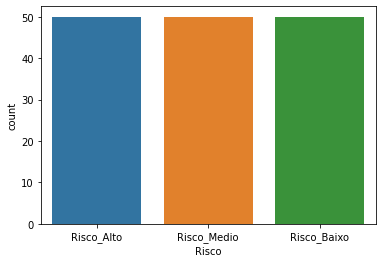

In [10]:
# Cria um gráfico de barras da variável Target
sns.countplot(dataset['Risco'])

# 2.0. FEATURE ENGINEERING 

In [48]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

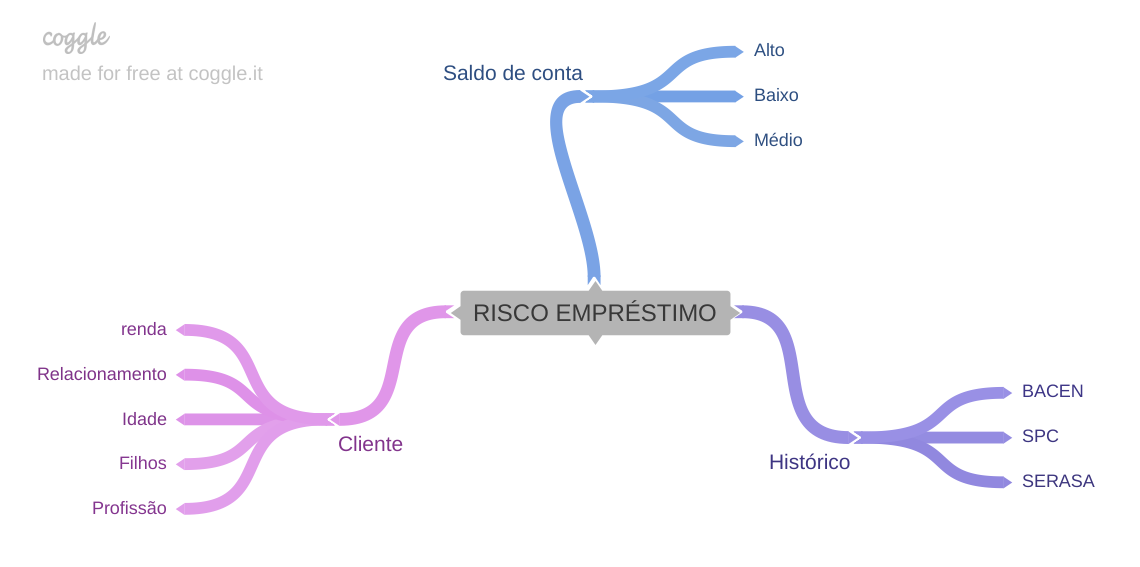

In [50]:
Image( 'img/RISCO_EMPRSTIMO.png')

## 2.2. Criação de Hipoteses 

**1.** Quanto maior o índice de inadimplência maior deveriam ser o risco (risco alto).


**2.** Clientes com saldo alto deveriam ter um risco baixo.


**3.** Clientes com anotações no Serasa, SPC, BACEN deveriam ter um risco baixo.


**4.** Cliente com maior renda deveriam ter um risco baixo. 

# 3.0. FILTRAGEM DE VARIAVEIS 

In [53]:
df3 = df2.copy()

## 3.1. Seleção de colunas

In [55]:
df3 = df3.drop(columns = 'id_cliente')

# 4.0.ANÁLISE EXPLORATÓRIA DE DADOS ( EDA)

In [57]:
df4=df3.copy()

## 4.1. Analise Univariada



### 4.1.1. Response Variable

C:\Users\mateu\anaconda3\envs\previsao_emprestimo\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


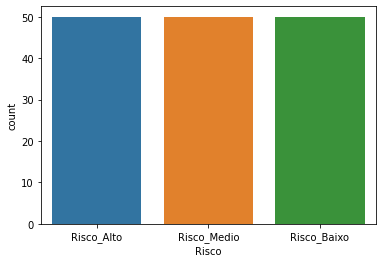

In [65]:
sns.countplot(dataset['Risco']);

### 4.1.2. Numerical Variable

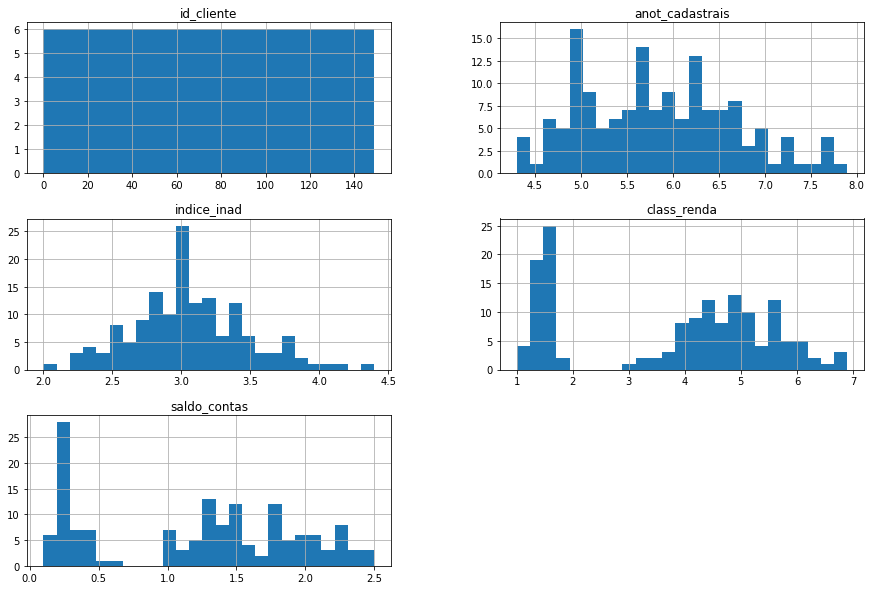

In [70]:
pylab.rcParams['figure.figsize'] = (15.0, 10.0)
num_attributes.hist(bins=25);

## 4.2. Analise Bivariada

### H1. Quanto maior o índice de inadimplência maior deveriam ser o risco (risco alto).

**TRUE** Quanto maior o risco de inadimplência maior o risco. 

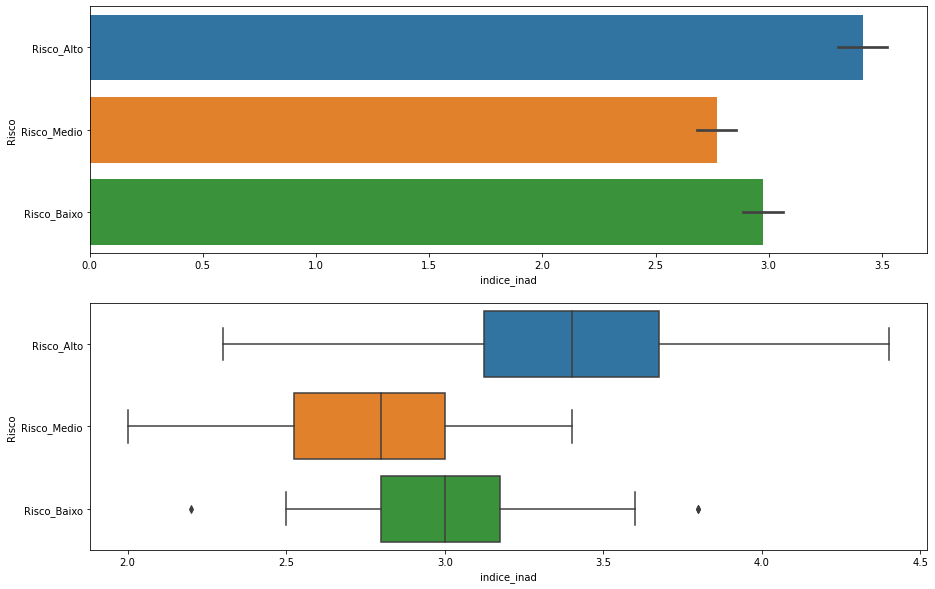

In [86]:
plt.subplot( 2, 1, 1 )
sns.barplot( x='indice_inad', y='Risco', data=df4 );

plt.subplot( 2, 1, 2 )
sns.boxplot( x='indice_inad', y='Risco', data=df4 );

### H2. Clientes com saldo elevado deveriam ter um risco baixo.
**TRUE** Clientes com saldo elevado tem um risco menor. 


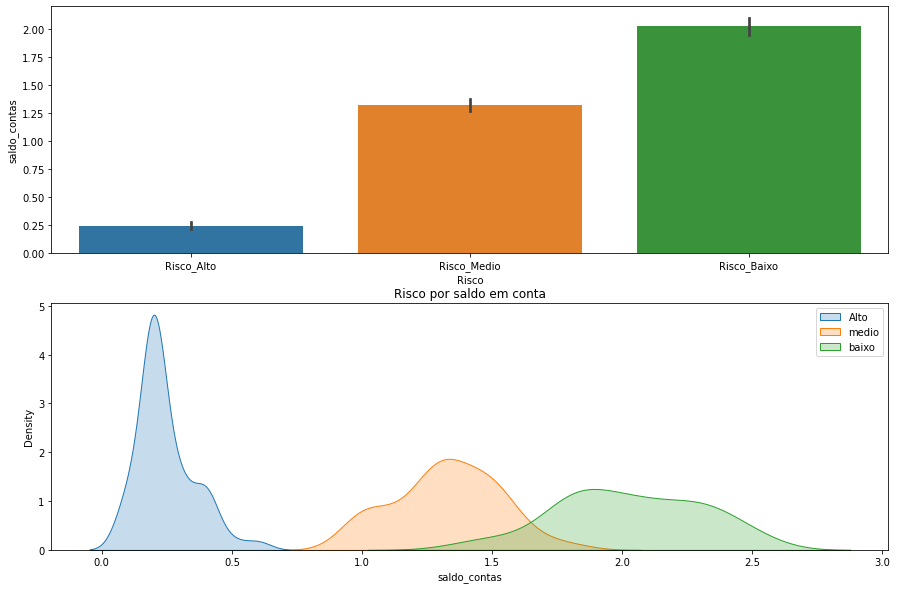

In [98]:
plt.subplot( 2, 1, 1 )
sns.barplot( x='Risco', y='saldo_contas', data=df4 )

plt.subplot( 2, 1, 2 )
sns.kdeplot( df4[df4['Risco'] == 'Risco_Alto']['saldo_contas'], label='Alto', shade=True )
sns.kdeplot( df4[df4['Risco'] == 'Risco_Medio']['saldo_contas'], label='medio', shade=True )
sns.kdeplot( df4[df4['Risco'] == 'Risco_Baixo']['saldo_contas'], label='baixo', shade=True )
plt.title( 'Risco por saldo em conta' )
plt.legend()

### H3. Quanto mais anotações no Serasa, SPC, BACEN o risco deveria ser maior.

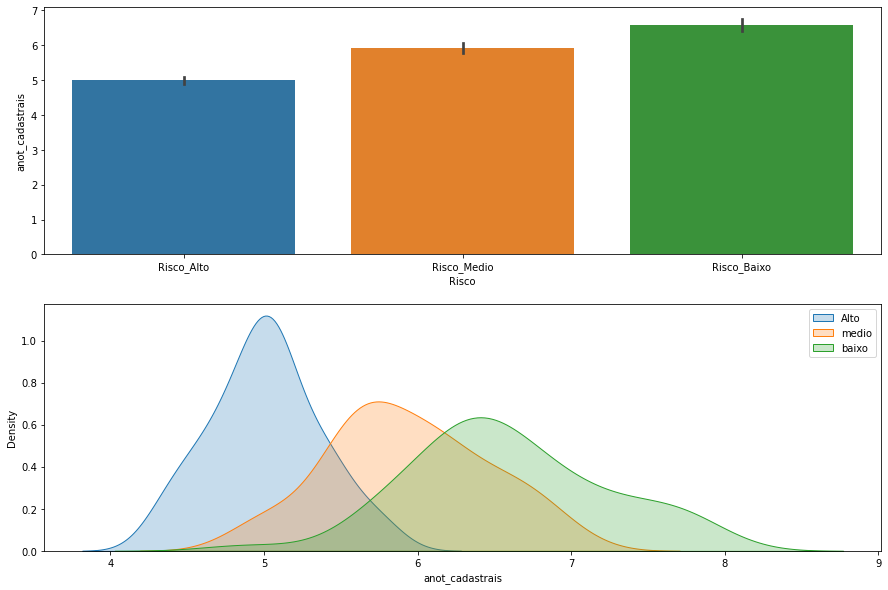

In [110]:
plt.subplot( 2, 1, 1 )
sns.barplot( x='Risco', y='anot_cadastrais', data=df4)

plt.subplot( 2, 1, 2 )
sns.kdeplot( df4[df4['Risco'] == 'Risco_Alto']['anot_cadastrais'], label='Alto', shade=True )
sns.kdeplot( df4[df4['Risco'] == 'Risco_Medio']['anot_cadastrais'], label='medio', shade=True )
sns.kdeplot( df4[df4['Risco'] == 'Risco_Baixo']['anot_cadastrais'], label='baixo', shade=True )
plt.legend()

### H4. Cliente com maior renda deveriam ter um risco baixo.

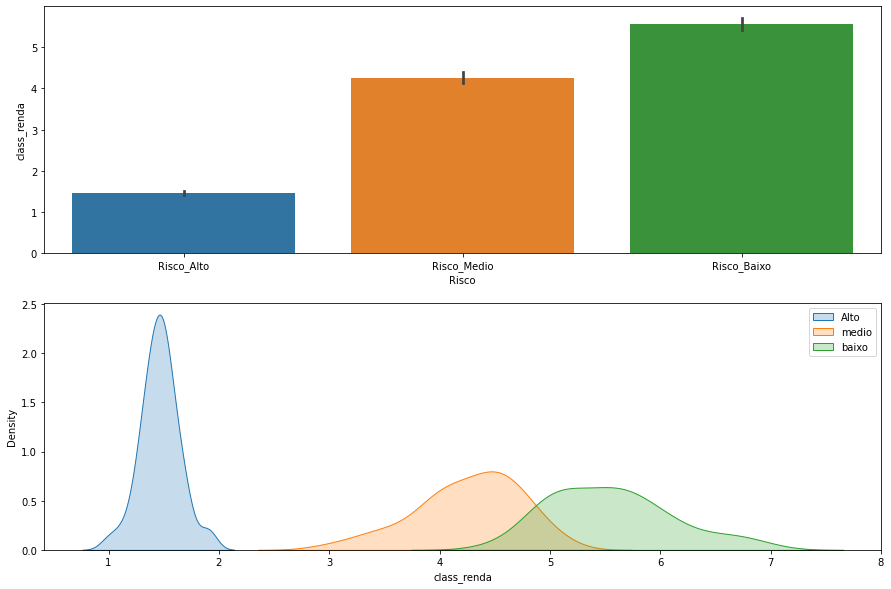

In [118]:
plt.subplot( 2, 1, 1 )
sns.barplot( x='Risco', y='class_renda', data=df4 )

plt.subplot( 2, 1, 2 )
sns.kdeplot( df4[df4['Risco'] == 'Risco_Alto']['class_renda'], label='Alto', shade=True )
sns.kdeplot( df4[df4['Risco'] == 'Risco_Medio']['class_renda'], label='medio', shade=True )
sns.kdeplot( df4[df4['Risco'] == 'Risco_Baixo']['class_renda'], label='baixo', shade=True )
plt.legend()

## 4.3. Analise Multivariada 

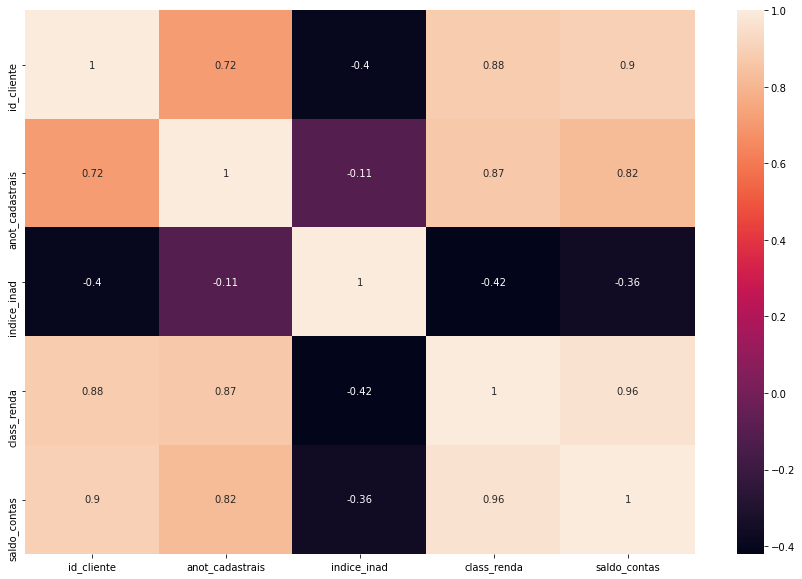

In [119]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 5.0. DATA PREPARATION

In [122]:
df5 = df4.copy()

## Rescaling

In [126]:
#RESCALA DOS DADOS USANDO ROBUST SCALER 
rs = RobustScaler()

df5['anot_cadastrais'] = rs.fit_transform( df5[['anot_cadastrais']].values )

df5['indice_inad'] = rs.fit_transform( df5[['indice_inad']].values )

df5['class_renda'] = rs.fit_transform( df5[['class_renda']].values )

df5['saldo_contas'] = rs.fit_transform( df5[['saldo_contas']].values )

# 6.0. MACHINE LEARNING MODELLING

In [177]:
#Separando as Variáveis de Entrada e Saída do Modelo
X = dataset.iloc[:,:-1].values  #variáveis independentes
y = dataset.iloc[:,-1].values  #Target/labe/class/vairável dependente

X_train, X_test, y_train, y_test = train_test_split( X ,y, test_size=0.2 )

In [142]:
print(f"Shape dos dados de treino é {X_train.shape}")
print(f"Shape dos dados de teste é {X_test.shape}")

Shape dos dados de treino é (120, 5)
Shape dos dados de teste é (30, 5)


In [178]:
# Modelos KNN
maquina_preditiva = KNeighborsClassifier( n_neighbors=30 )

#Modelo SVC
classifier = SVC( kernel='linear', gamma= 1e-5,  C=10 )

In [153]:
#Treinando a Máquina preditiva com os dados de treino
maquina_preditiva = maquina_preditiva.fit( X_train, y_train )
classifier.fit( X_train,y_train )


SVC(C=10, gamma=1e-05, kernel='linear')

In [157]:
#Acurracia KNeighborsClassifier
print("Acurácia da Máquina = ", metrics.accuracy_score(y_test, y_pred)*100)

Acurácia da Máquina =  100.0


In [158]:
#AURRACIA DA SVC
print("Prediction Accuracy = ", metrics.accuracy_score(y_test, y_pred))

# Comparando valores Reais com Preditos pela Máquina
print("\nActual vs Predicted  \n------------------------------\n")
error_df = pd.DataFrame({"Actual" : y_test,
                         "Predicted" : y_pred})

error_df.head(5)

Prediction Accuracy =  1.0

Actual vs Predicted  
------------------------------



,Actual,Predicted
0,Risco_Alto,Risco_Alto
1,Risco_Baixo,Risco_Baixo
2,Risco_Alto,Risco_Alto
3,Risco_Medio,Risco_Medio
4,Risco_Alto,Risco_Alto


In [176]:
#Matrix de confusão e classification report 
cm = confusion_matrix(y_test,y_pred)
cr = classification_report(y_test, y_pred)
print(cm)
print(cr)

[[ 7  0  0]
 [ 0  7  0]
 [ 0  0 16]]
              precision    recall  f1-score   support

  Risco_Alto       1.00      1.00      1.00         7
 Risco_Baixo       1.00      1.00      1.00         7
 Risco_Medio       1.00      1.00      1.00        16

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

